In [1]:
import os
import datetime

import matplotlib.pyplot as plt
# import scienceplots
# plt.style.use("science")

import pandas as pd
pd.set_option("display.max_columns", None)

EPADU = 10.0
OBSV_DATES = [
    datetime.date(year=2022, month=10, day=21).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=10, day=27).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=11, day=5).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=11, day=26).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=7).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=9).strftime("%Y-%m-%d"),
    datetime.date(year=2022, month=12, day=10).strftime("%Y-%m-%d"),
]
# TODO on run: update this whenever reference star targets change
STAR_LIDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

# OBJ_DATA_DIR = "/run/media/ramon/USBD/Tesis/IturbideDatos/ATOJ339.9469+45.1464/"
OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"
EPADU = 10.0

QPHOT_DATA_DIRS = [os.path.join(OBJ_DATA_DIR, d, "corrected", "iraf-shifted", "qphot-results") for d in OBSV_DATES]
for qphotDir in QPHOT_DATA_DIRS:
    assert os.path.exists(qphotDir), f"{qphotDir} not found"

QPHOT_DATA_DIRS

['/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-21/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-10-27/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-05/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-26/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-07/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-09/corrected/iraf-shifted/qphot-results',
 '/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-10/corrected/iraf-shifted/qphot-results']

In [2]:
from astropy.io import ascii

QPHOT_RESULTS = {d:ascii.read(f"{qphotDir}/phot").to_pandas() for d, qphotDir in zip(OBSV_DATES, QPHOT_DATA_DIRS)}
for qphotDateResults in QPHOT_RESULTS.values():
    qphotDateResults['OTIME'] = pd.to_datetime(qphotDateResults['OTIME']).dt.tz_localize('America/Monterrey')
    qphotDateResults['julianDate'] = qphotDateResults['OTIME'].map(lambda d: d.to_julian_date())
    qphotDateResults.sort_values(by='julianDate', inplace=True)

/tmp/ipykernel_257287/2096144024.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{rid} - {qphotDateResults[f'RAPERT{rid}'].iloc[0]}" for rid in rapertDataVariance.keys()])


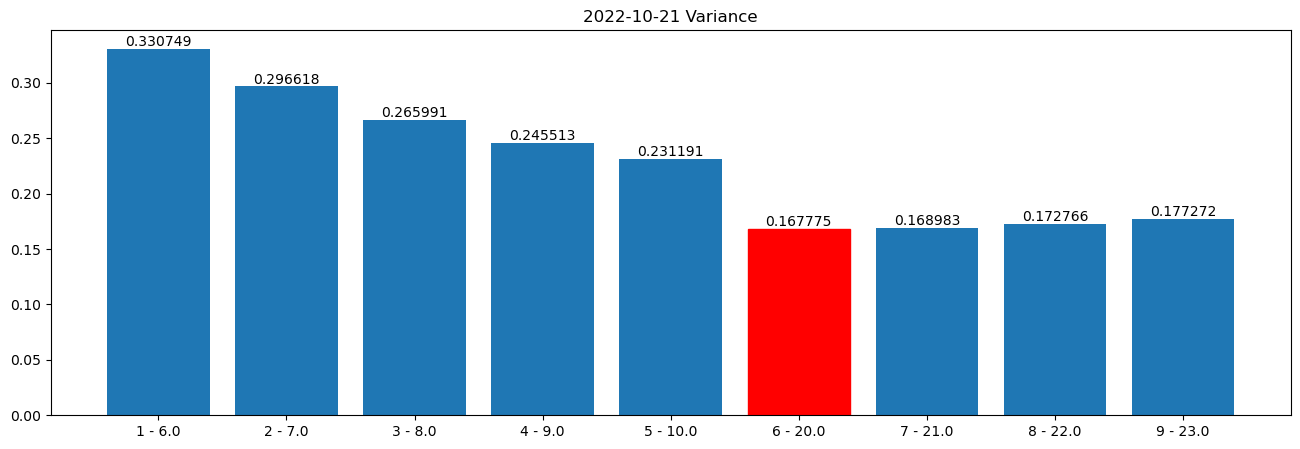

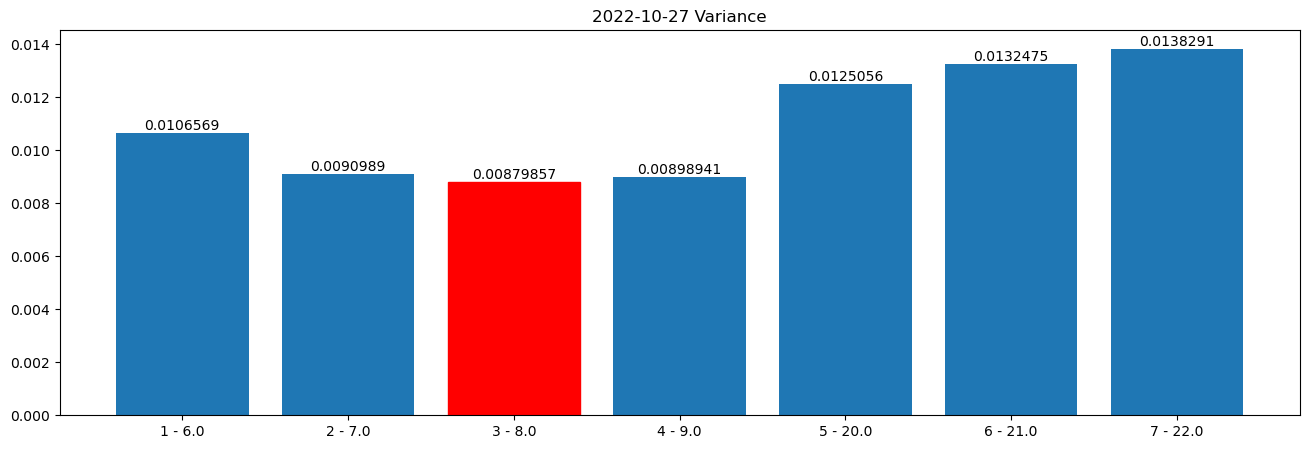

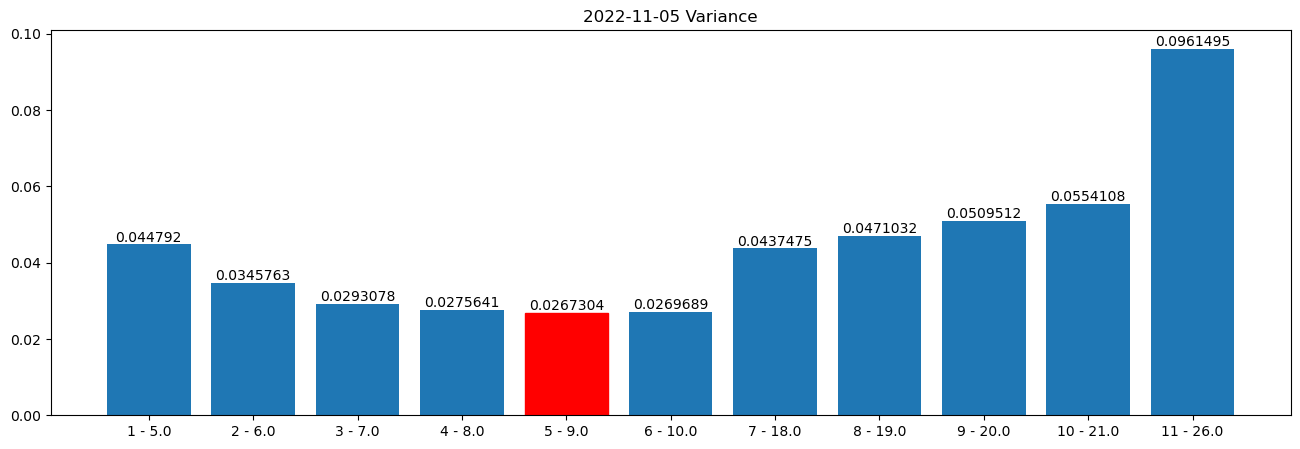

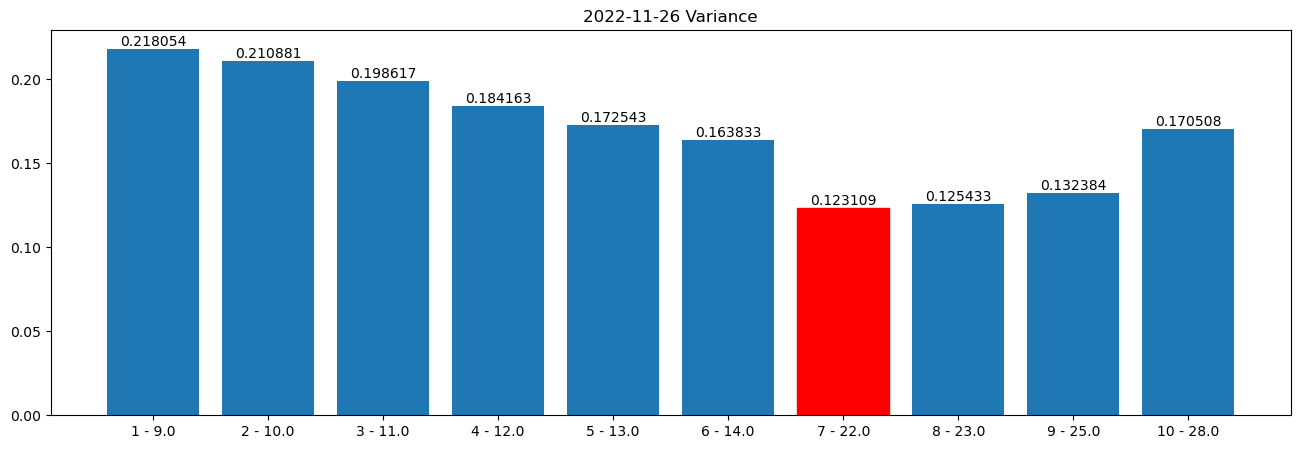

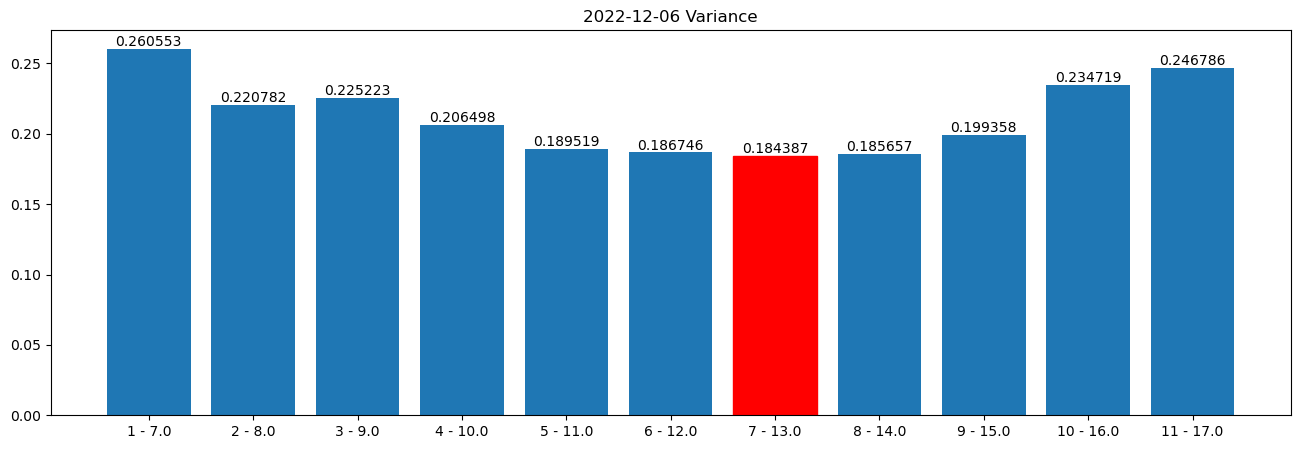

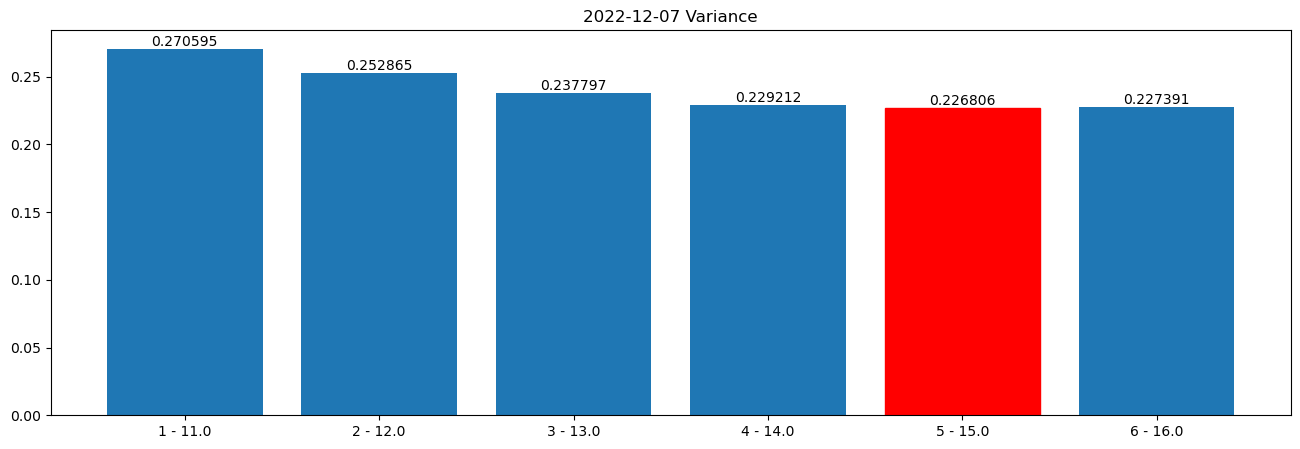

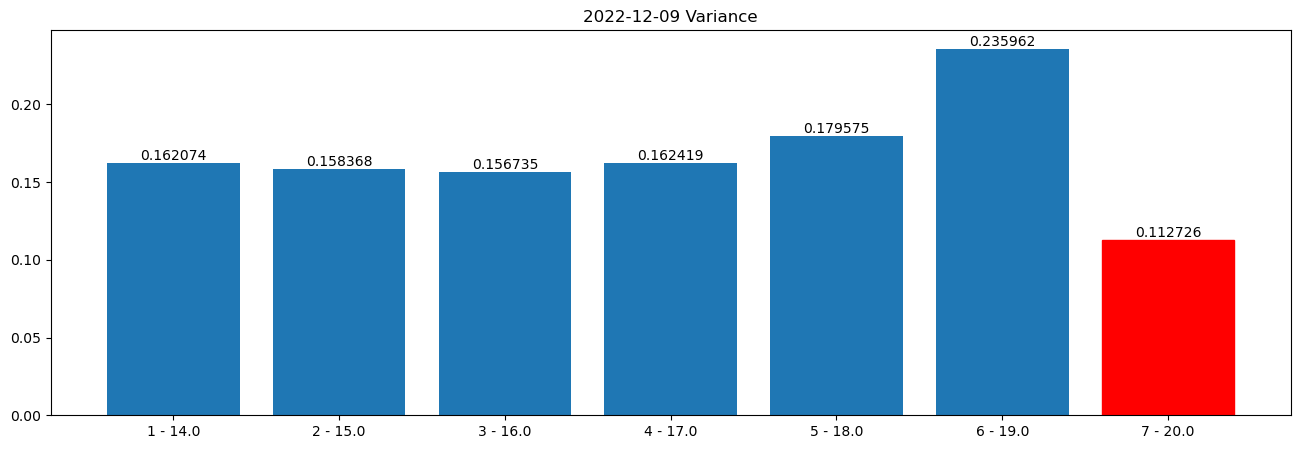

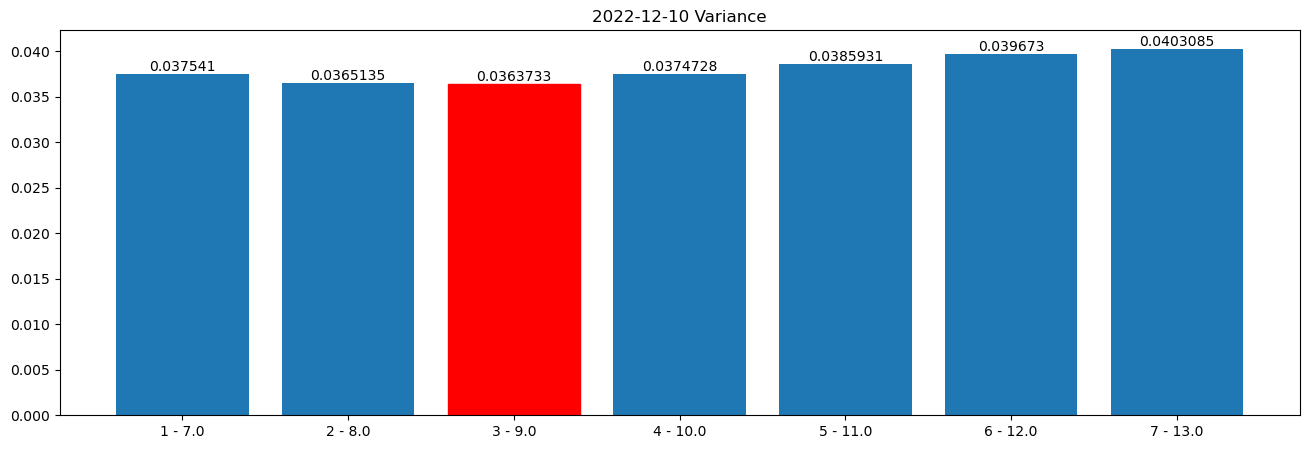

{'2022-10-21': '6',
 '2022-10-27': '3',
 '2022-11-05': '5',
 '2022-11-26': '7',
 '2022-12-06': '7',
 '2022-12-07': '5',
 '2022-12-09': '7',
 '2022-12-10': '3'}

In [3]:
# examine standard deviation of ref. stars
	# will use for determining which aperture is actually best
import numpy as np

PLOT = True
COMP_STAR_LID = 2 # using TYC 3620-332-1 as the constant star for quality assurance
OBSV_DATES_APERS = {}
for obsvDate, qphotDateResults in QPHOT_RESULTS.items():
    qphotDateResults = QPHOT_RESULTS[obsvDate]

    rapertIds = [c.replace('RAPERT', '') for c in qphotDateResults.columns if 'RAPERT' in c]
    obj_qphot = qphotDateResults[qphotDateResults['LID'] == 1]
    comp_qphot = qphotDateResults[qphotDateResults['LID'] == COMP_STAR_LID]

    rapertDataVariance: dict[str, float] = {}
    lowestVar = 1e5 # arbitrary high variance to initialize
    for rid in rapertIds:
        MAG_COL = f"MAG{rid}"
        rapertVar = np.var(obj_qphot[MAG_COL])
        if rapertVar < lowestVar:
            lowestVar = rapertVar
            OBSV_DATES_APERS[obsvDate] = rid
        rapertDataVariance[rid] = rapertVar

    if PLOT:
        fig, ax = plt.subplots(figsize=(16, 5))
        barList = ax.bar(rapertDataVariance.keys(), rapertDataVariance.values())
        barList[list(rapertDataVariance.keys()).index(OBSV_DATES_APERS[obsvDate])].set_color('r')
        ax.bar_label(barList)
        ax.set_xticklabels([f"{rid} - {qphotDateResults[f'RAPERT{rid}'].iloc[0]}" for rid in rapertDataVariance.keys()])
        plt.title(obsvDate + " Variance")
        plt.show()
OBSV_DATES_APERS

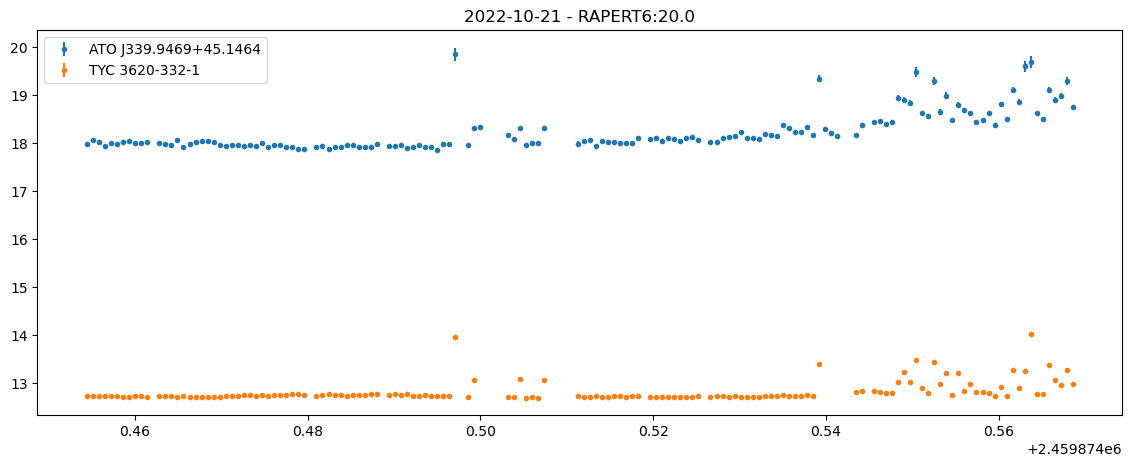

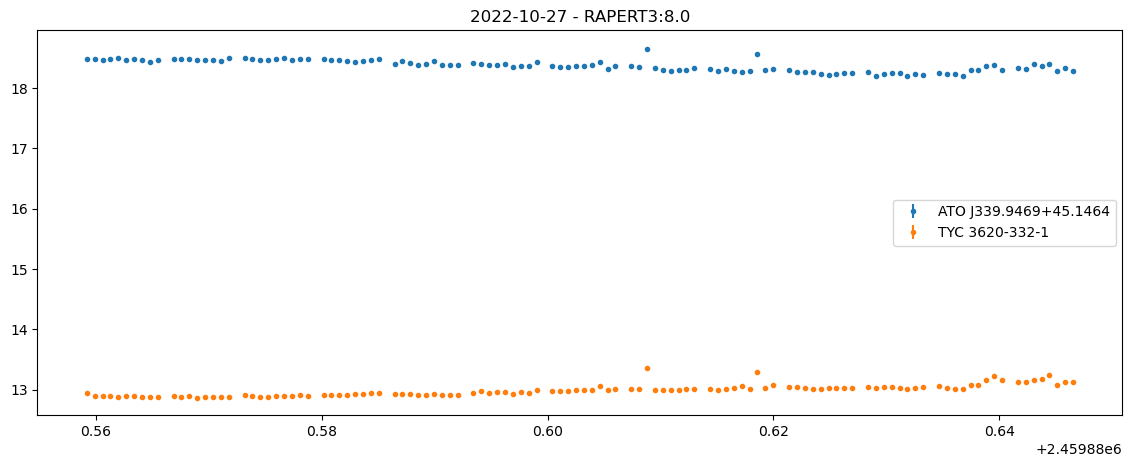

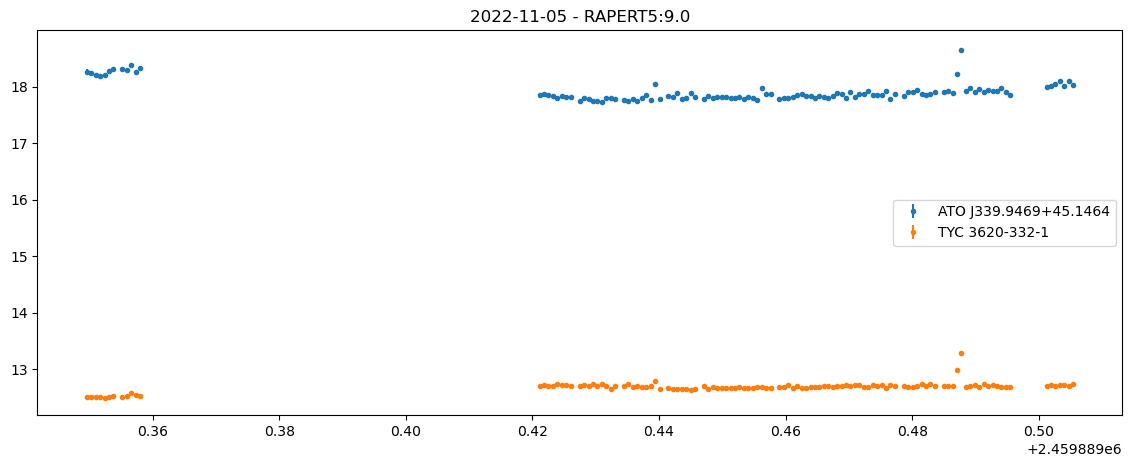

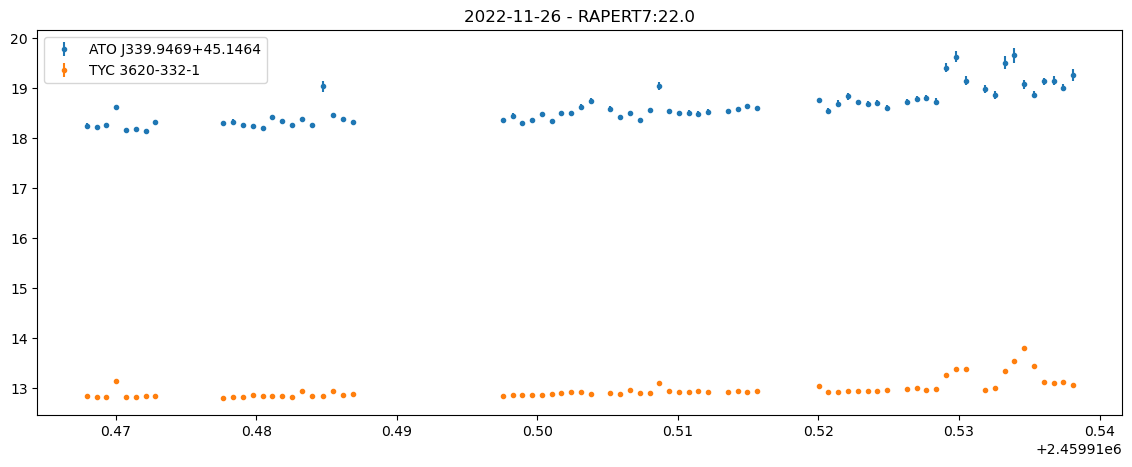

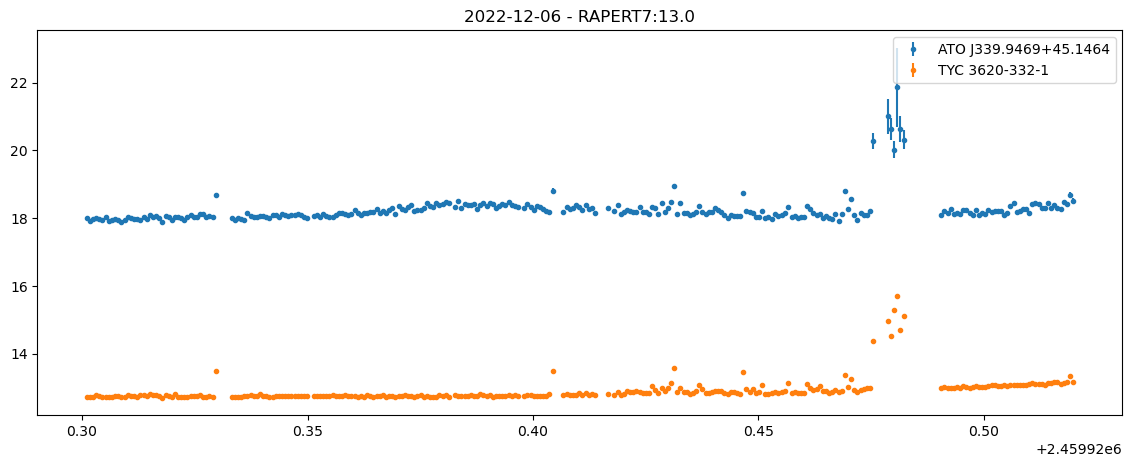

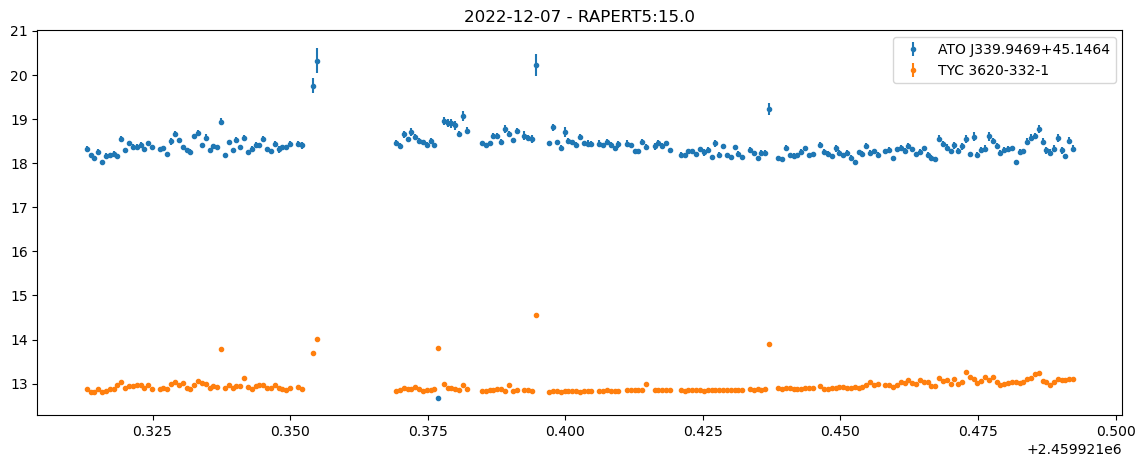

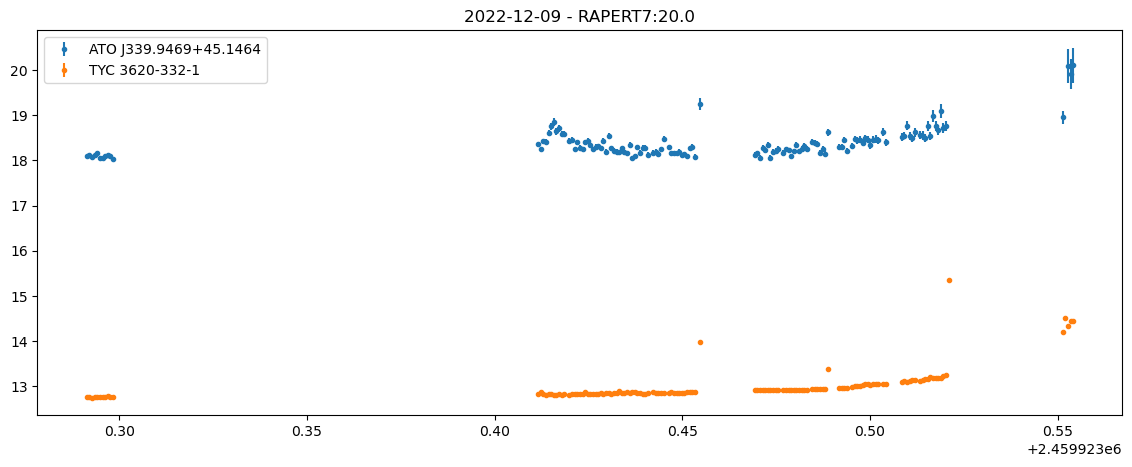

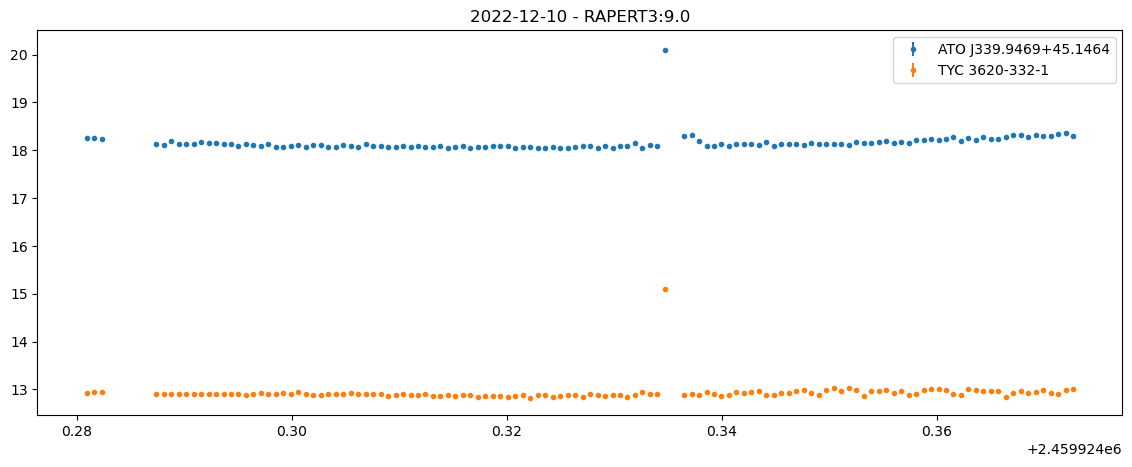

In [4]:
# spot checking above solution
# looks to be a decent fit; using variance score to choose which aperture to use

for obsvDate, rid in OBSV_DATES_APERS.items():
	qphotDateResults = QPHOT_RESULTS[obsvDate]
	obj_qphot = qphotDateResults[qphotDateResults['LID'] == 1]
	comp_qphot = qphotDateResults[qphotDateResults['LID'] == COMP_STAR_LID]

	plt.figure(figsize=(14,5))
	plt.errorbar(obj_qphot['julianDate'], obj_qphot[f'MAG{rid}'], obj_qphot[f'MERR{rid}'], label=STAR_LIDS[1], fmt='.')
	plt.errorbar(comp_qphot['julianDate'], comp_qphot[f'MAG{rid}'], comp_qphot[f'MERR{rid}'], label=STAR_LIDS[COMP_STAR_LID], fmt='.')
	plt.title(f"{obsvDate} - RAPERT{rid}:{qphotDateResults[f'RAPERT{rid}'].iloc[0]}")
	plt.legend()
	plt.show()

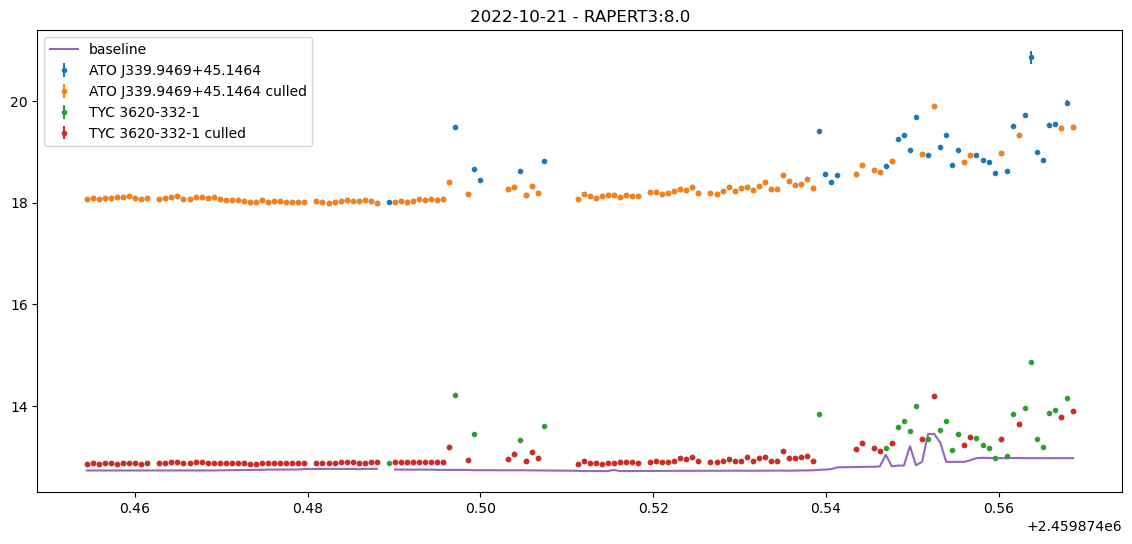

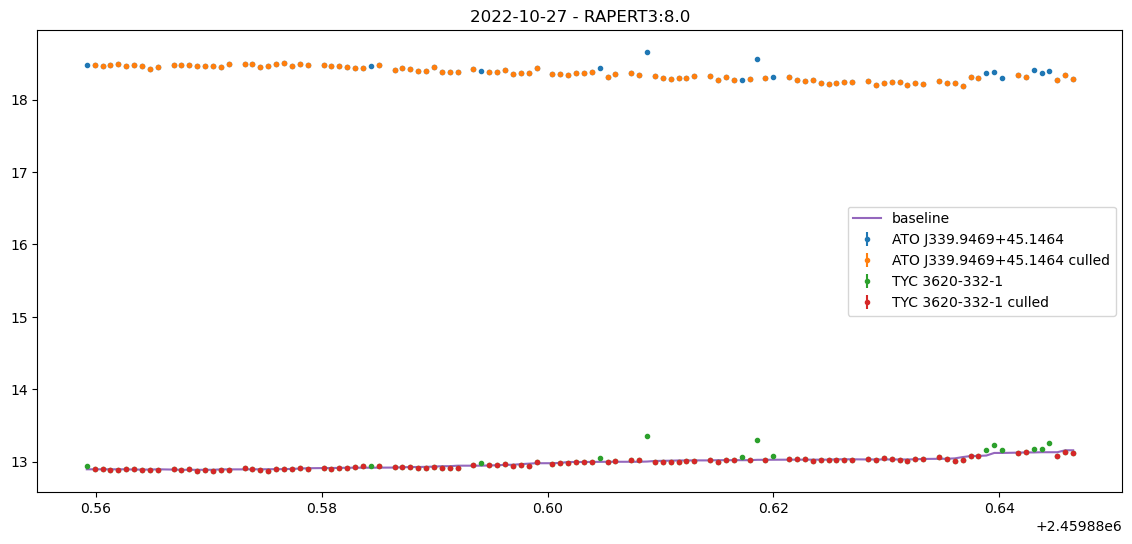

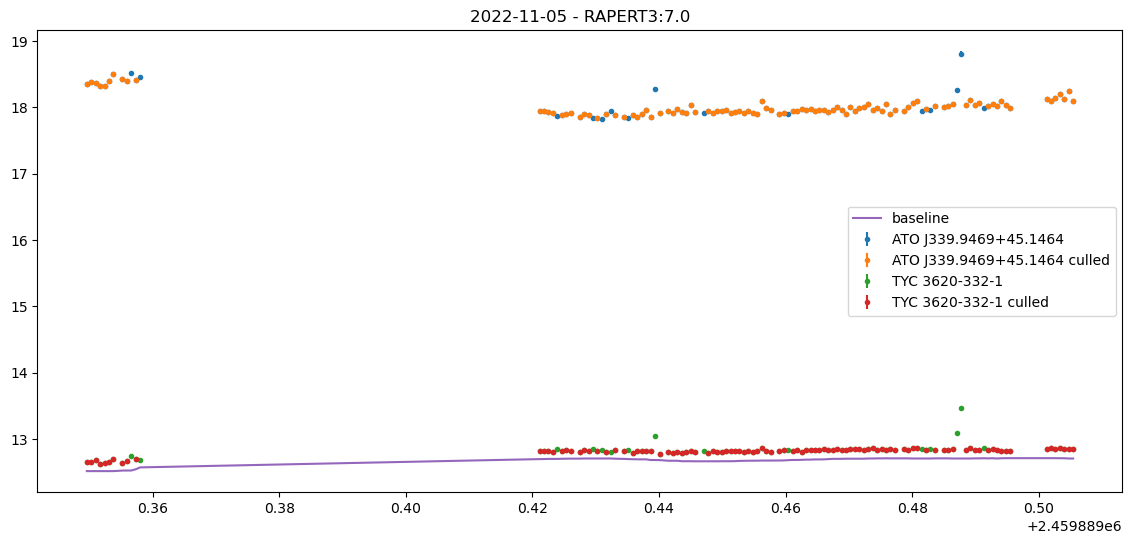

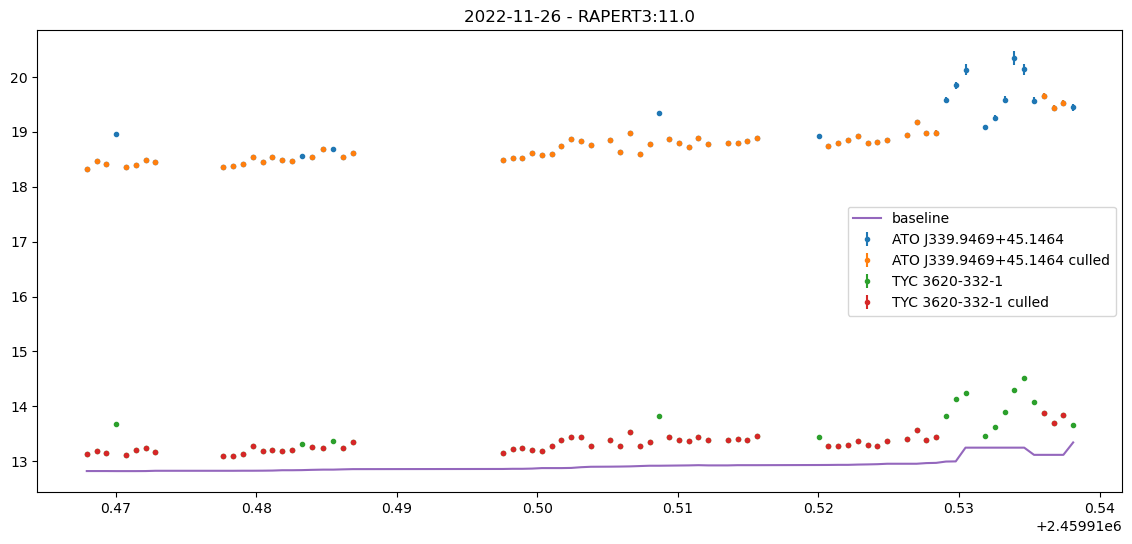

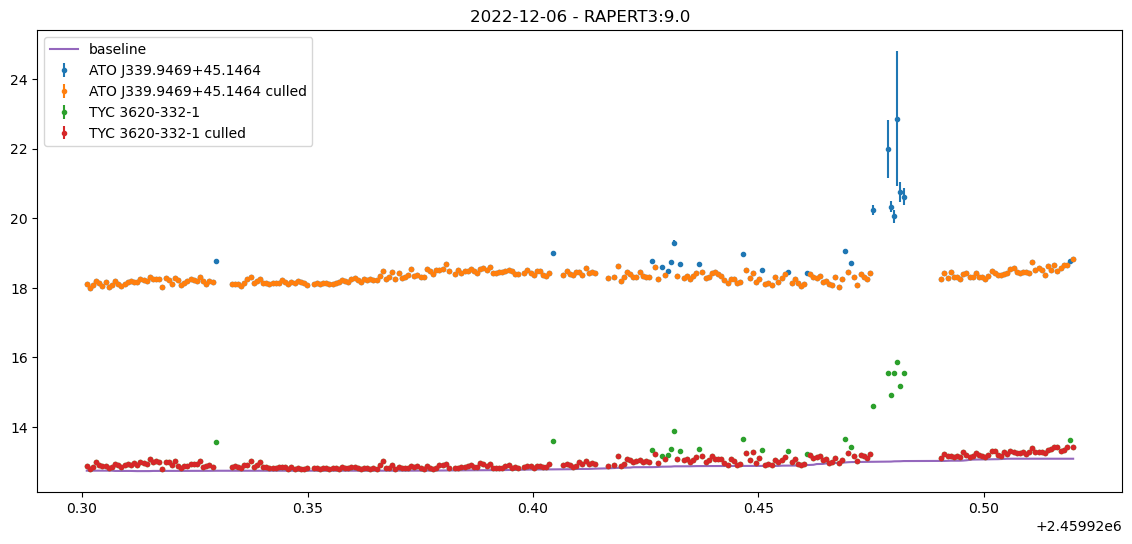

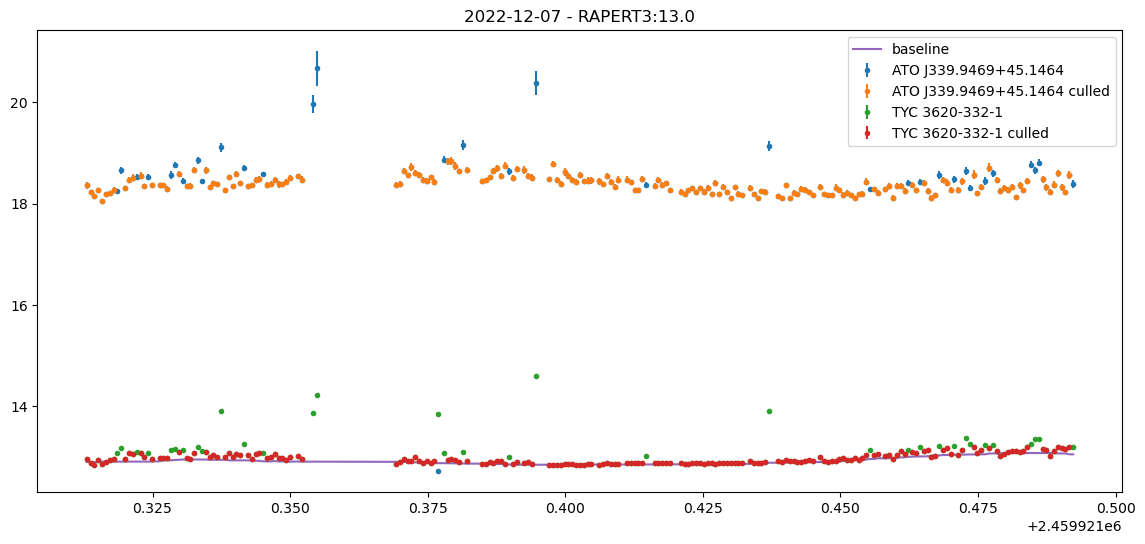

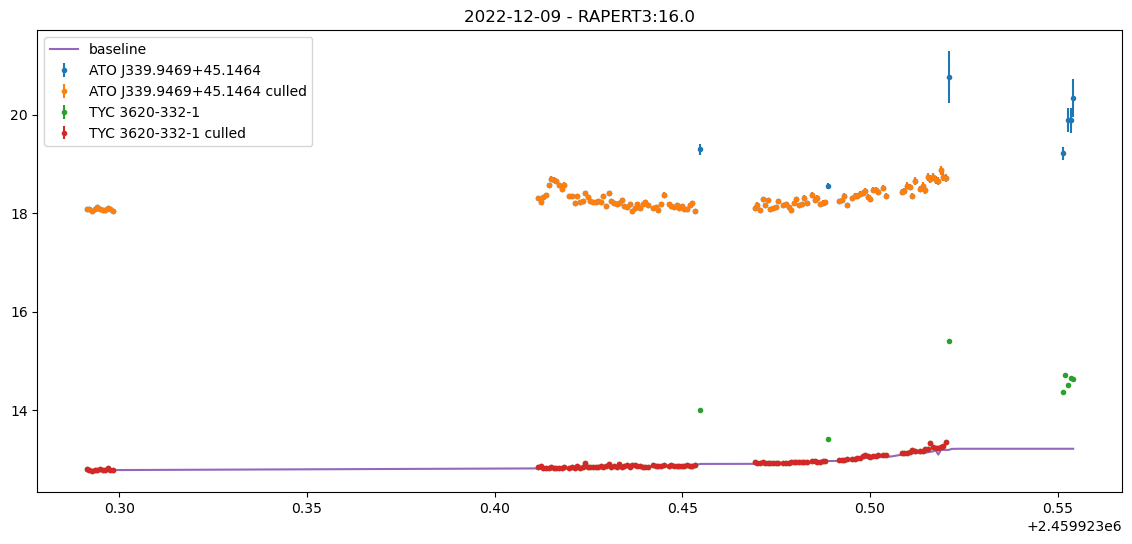

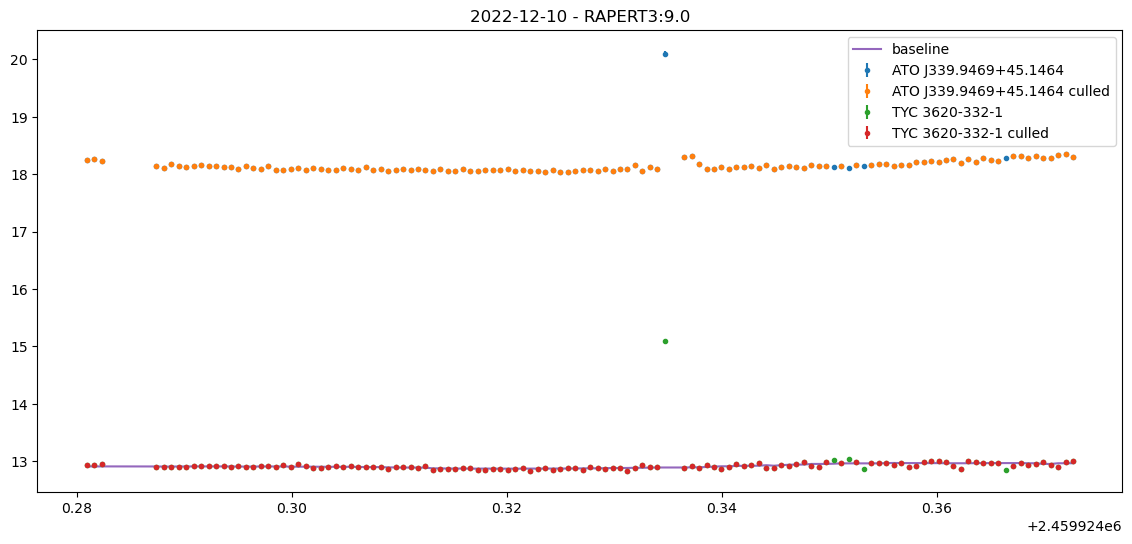

In [5]:
from scipy.ndimage import median_filter

CULLED_FLTRS = {}
for obsvDate, rapertId in OBSV_DATES_APERS.items():
	qphotDateResults = QPHOT_RESULTS[obsvDate]
	obj_qphot = qphotDateResults[qphotDateResults['LID'] == 1].reset_index()
	comp_qphot = qphotDateResults[qphotDateResults['LID'] == COMP_STAR_LID].reset_index()

	initSigma = np.std(comp_qphot[f'MAG{rapertId}'])
	xi_low = 0.5
	xi_high = 0.3
	baseline = median_filter(comp_qphot[f'MAG{rapertId}'], size=len(comp_qphot)//5, mode='mirror')
	fltr = (comp_qphot[f'MAG{rapertId}'] - baseline > (-xi_low)*initSigma) & (comp_qphot[f'MAG{rapertId}'] - baseline < xi_high*initSigma)
	CULLED_FLTRS[obsvDate] = fltr

	plt.figure(figsize=(14,6))
	plt.errorbar(obj_qphot['julianDate'], obj_qphot[f'MAG{rid}'], obj_qphot[f'MERR{rid}'], label=STAR_LIDS[1], fmt='.')
	plt.errorbar(obj_qphot['julianDate'][fltr], obj_qphot[f'MAG{rid}'][fltr], obj_qphot[f'MERR{rid}'][fltr], label=f"{STAR_LIDS[1]} culled", fmt='.')
	plt.errorbar(comp_qphot['julianDate'], comp_qphot[f'MAG{rid}'], comp_qphot[f'MERR{rid}'], label=STAR_LIDS[COMP_STAR_LID], fmt='.')
	plt.errorbar(comp_qphot['julianDate'][fltr], comp_qphot[f'MAG{rid}'][fltr], comp_qphot[f'MERR{rid}'][fltr], label=f"{STAR_LIDS[COMP_STAR_LID]} culled", fmt='.')
	plt.plot(comp_qphot['julianDate'], baseline, label='baseline')
	plt.legend()
	plt.title(f"{obsvDate} - RAPERT{rid}:{qphotDateResults[f'RAPERT{rid}'].iloc[0]}")
	plt.show()

/tmp/ipykernel_257287/1461987737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(


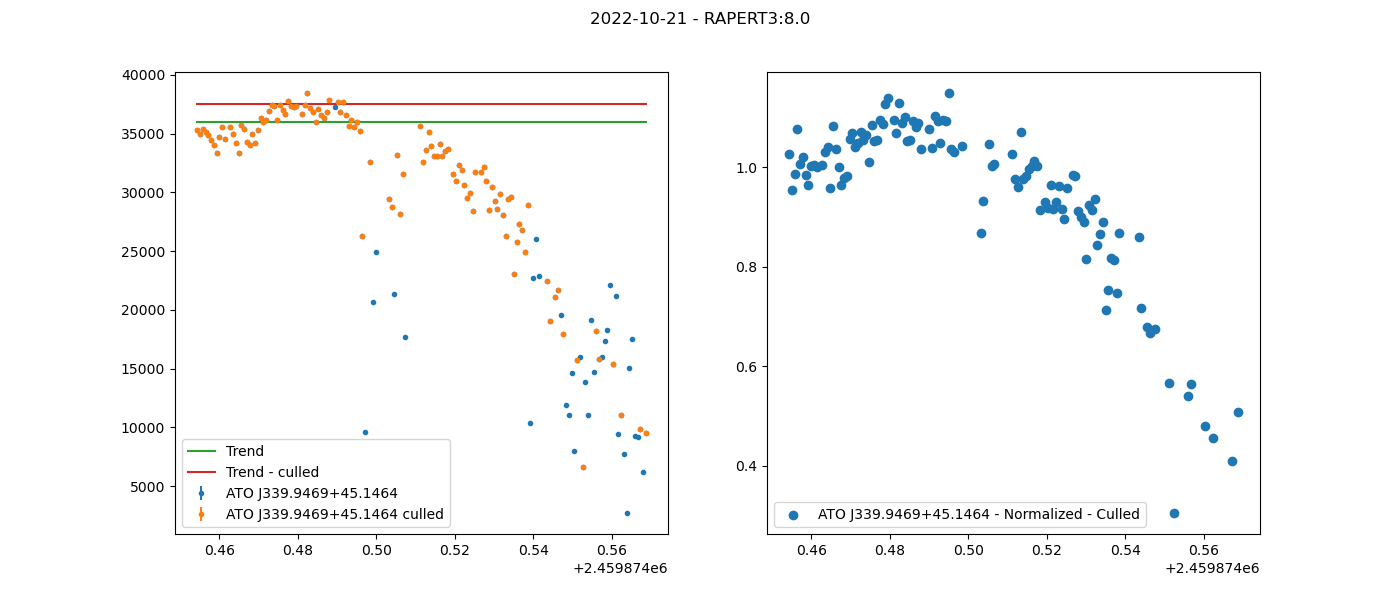

/tmp/ipykernel_257287/1461987737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(


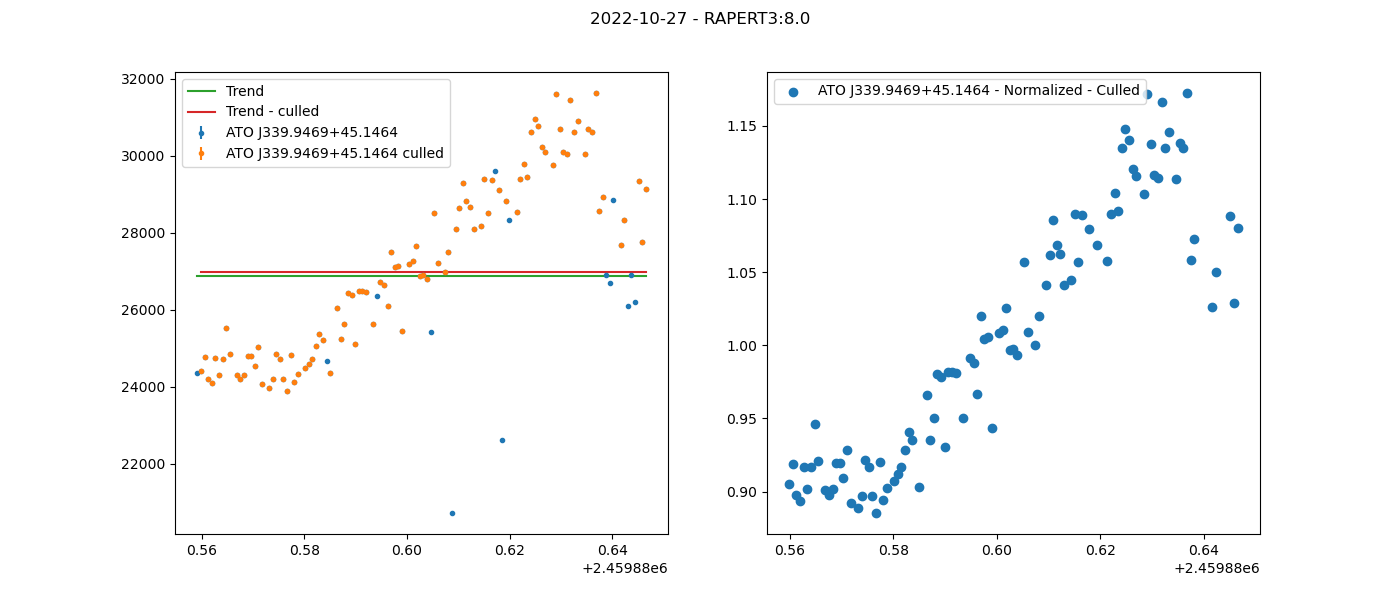

/tmp/ipykernel_257287/1461987737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(


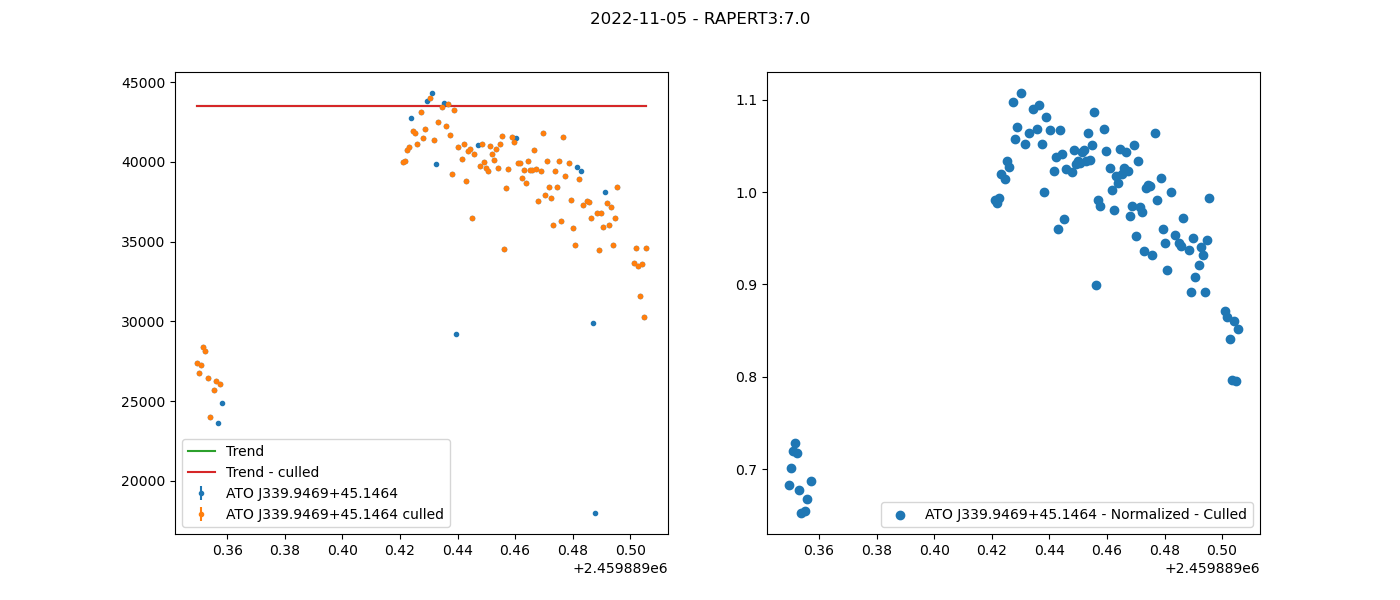

/tmp/ipykernel_257287/1461987737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(


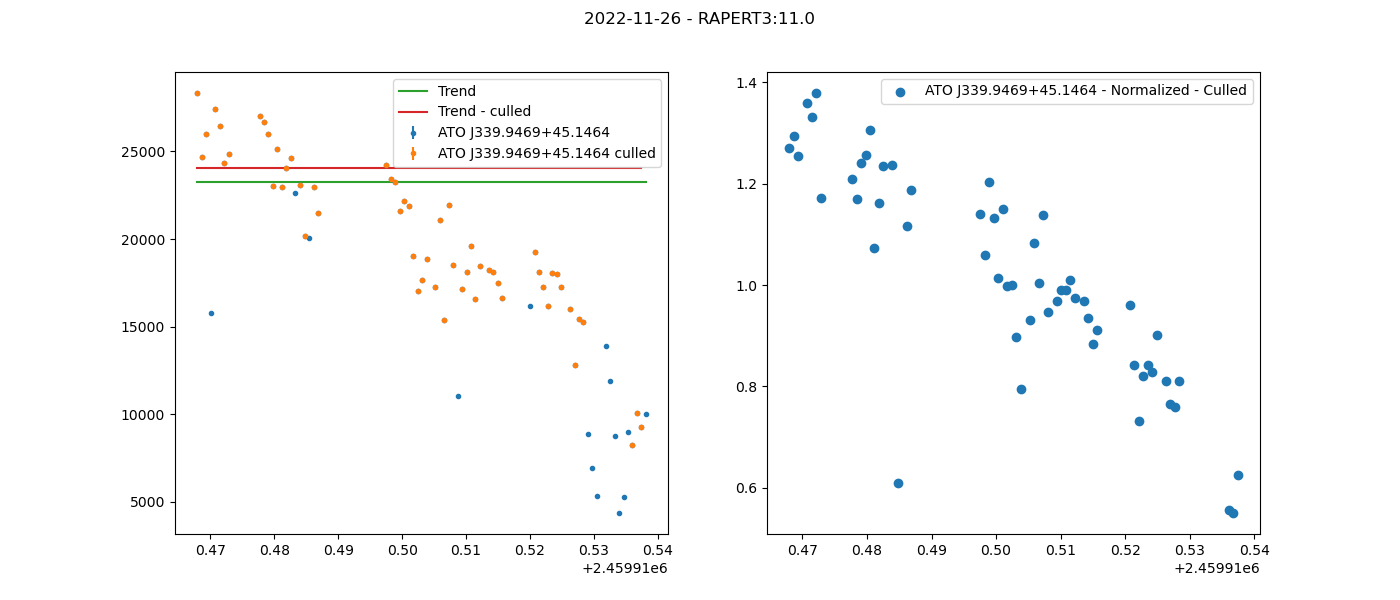

/tmp/ipykernel_257287/1461987737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(


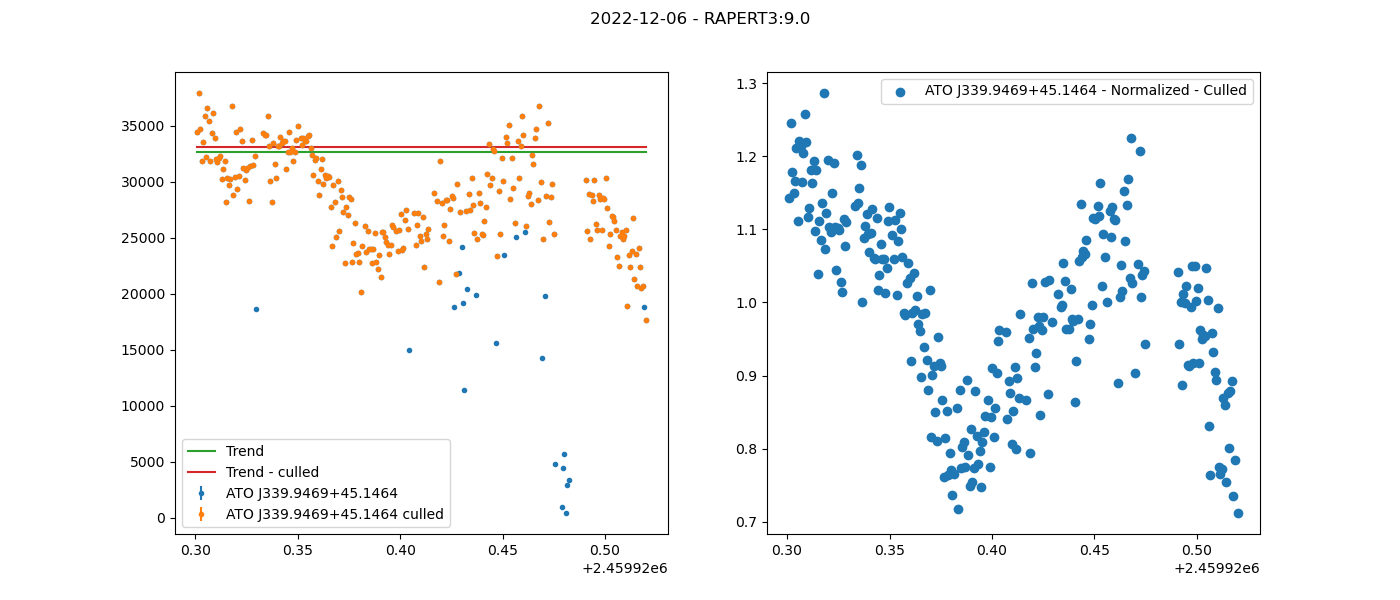

/tmp/ipykernel_257287/1461987737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(


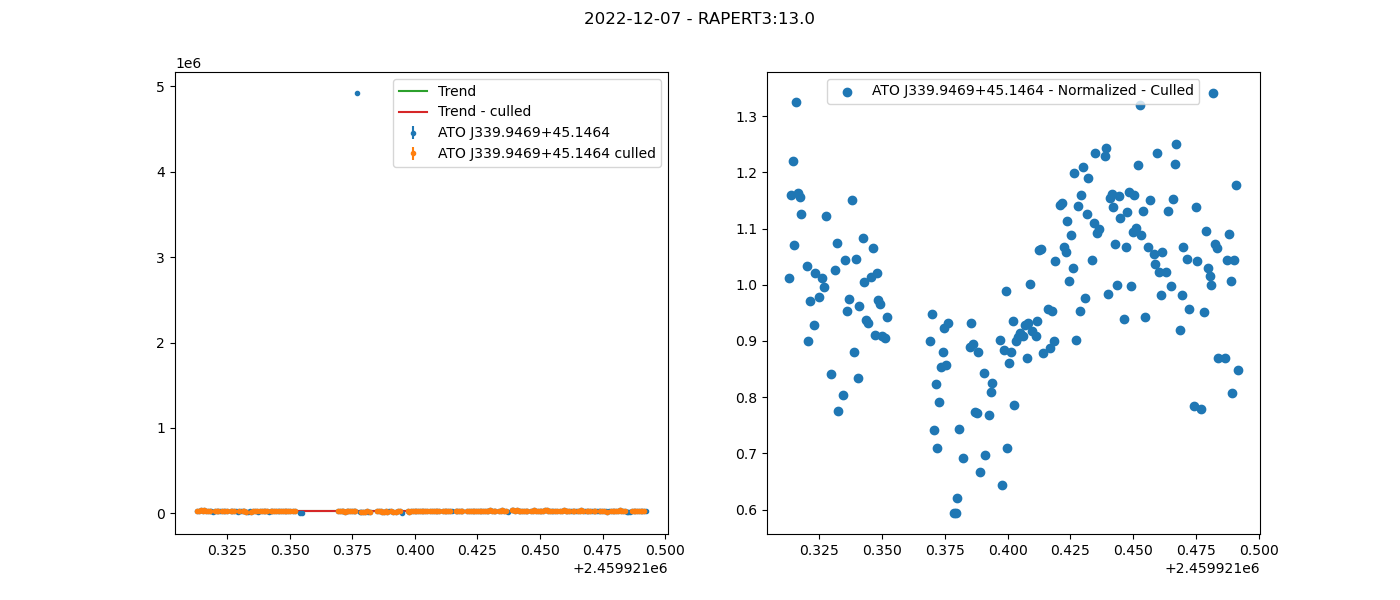

/tmp/ipykernel_257287/1461987737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(


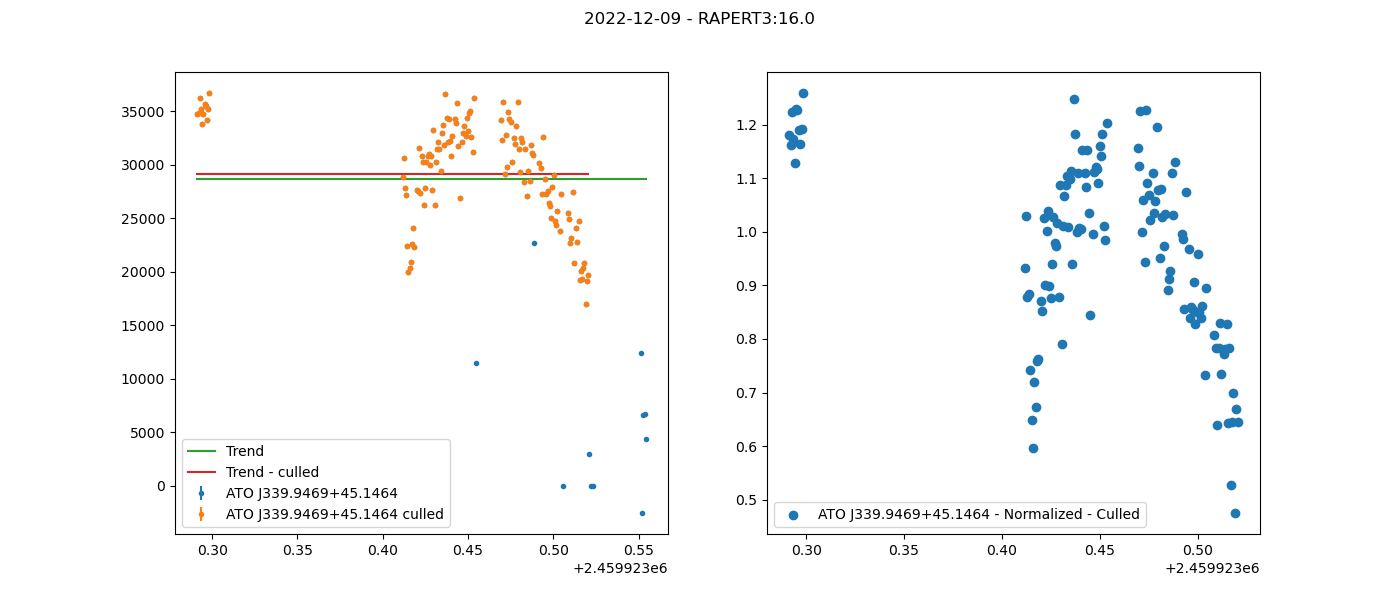

/tmp/ipykernel_257287/1461987737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(


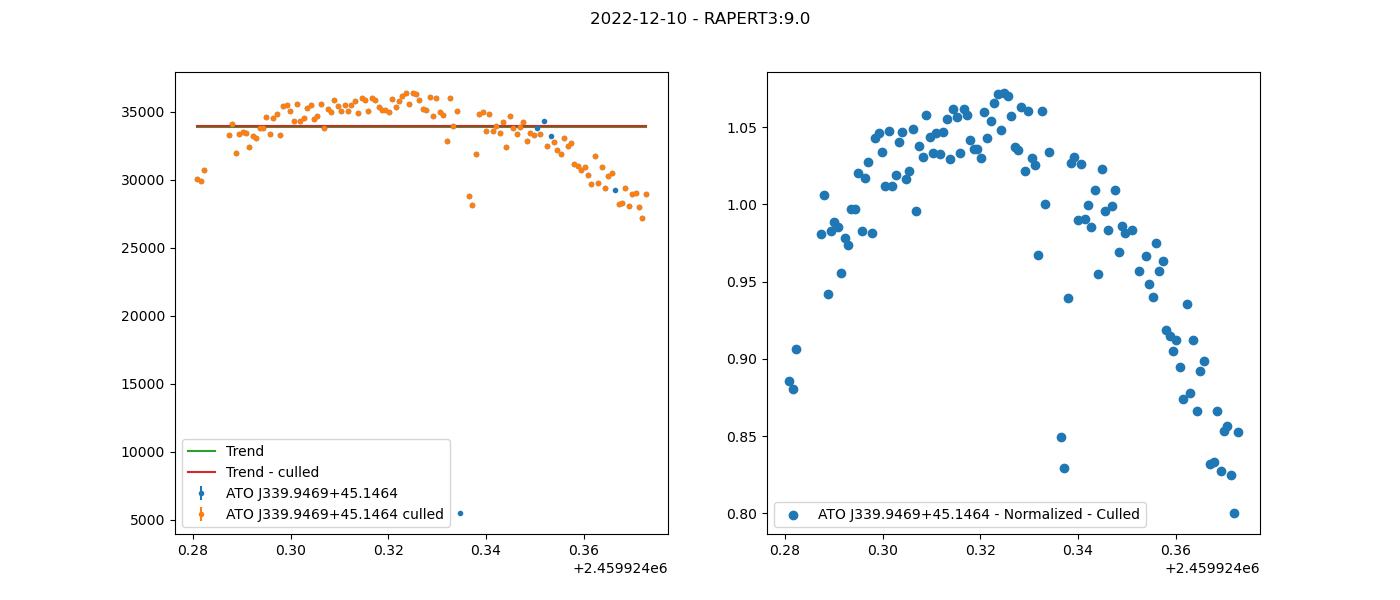

In [19]:
import astropy.units as u
from astropy.timeseries import TimeSeries

PLOT_INDIVIDUAL = True

allObjDf = pd.DataFrame(columns=['MAG', 'MERR', 'FLUX', 'FERR', 'NORM_FLUX', 'OTIME', 'obsv_date', 'julianDate'])
for obsvDate in OBSV_DATES:
	qphotDateResults = QPHOT_RESULTS[obsvDate]
	fltr = CULLED_FLTRS[obsvDate]
	rapertId = OBSV_DATES_APERS[obsvDate]
	rapert = float(qphotDateResults[f'RAPERT{rapertId}'].iloc[0])

	obj_qphot = qphotDateResults[qphotDateResults['LID'] == 1].reset_index()
	culled_obj_qphot = obj_qphot[fltr]
	
	trend = median_filter(obj_qphot[f'FLUX{rapertId}'], size=len(obj_qphot), mode='wrap')
	trend_culled = median_filter(obj_qphot[f'FLUX{rapertId}'][fltr], size=len(culled_obj_qphot), mode='wrap')
	culled_norm_flux = ((culled_obj_qphot[f'FLUX{rapertId}'] - trend_culled) + np.median(trend_culled)) / np.median(trend_culled)

	culled_obj_qphot[f'FERR{rapertId}'] = np.sqrt(
                                    (culled_obj_qphot[f'FLUX{rapertId}']/EPADU) 
                                       + (culled_obj_qphot[f'AREA{rapertId}']*culled_obj_qphot['STDEV']**2)
                                       + ((culled_obj_qphot[f'AREA{rapertId}']**2)  * ((culled_obj_qphot['STDEV']**2)/culled_obj_qphot['NSKY']))
                                )
	
	dateDf = pd.DataFrame(data={
		'obsv_date': obsvDate,
		'julianDate': culled_obj_qphot['julianDate'],
		'OTIME': culled_obj_qphot['OTIME'],
		'MAG': culled_obj_qphot[f'MAG{rapertId}'],
		'MERR': culled_obj_qphot[f'MERR{rapertId}'],
		'FLUX': culled_obj_qphot[f'FLUX{rapertId}'],
		'FERR': culled_obj_qphot[f'FERR{rapertId}'],
		'NORM_FLUX': culled_norm_flux,
		'RAPERT': rapert*np.ones_like(culled_norm_flux)
	})
	allObjDf = pd.concat([allObjDf, dateDf])

	if PLOT_INDIVIDUAL:
		fig, axs = plt.subplots(1, 2, figsize=(14,6))
		axs[0].errorbar(obj_qphot['julianDate'], obj_qphot[f'FLUX{rid}'], obj_qphot[f'MERR{rid}'], label=STAR_LIDS[1], fmt='.')
		axs[0].errorbar(culled_obj_qphot['julianDate'], culled_obj_qphot[f'FLUX{rid}'], obj_qphot[f'MERR{rid}'][fltr], label=f"{STAR_LIDS[1]} culled", fmt='.')
		axs[0].plot(obj_qphot['julianDate'], trend, label='Trend')
		axs[0].plot(culled_obj_qphot['julianDate'], trend_culled, label='Trend - culled')
		axs[0].legend()

		axs[1].scatter(culled_obj_qphot['julianDate'], culled_norm_flux, label=f"{STAR_LIDS[1]} - Normalized - Culled")
		axs[1].legend()
		fig.suptitle(f"{obsvDate} - RAPERT{rid}:{qphotDateResults[f'RAPERT{rid}'].iloc[0]}")
		plt.show()

,MAG,MERR,FLUX,FERR,NORM_FLUX,OTIME,obsv_date,julianDate,RAPERT
0,17.981,0.031,38512.91,1088.952417,1.026568,2022-10-21 22:54:21.841000-05:00,2022-10-21,2.459874e+06,20.0
1,18.061,0.027,35790.91,876.946726,0.954013,2022-10-21 22:55:22.219000-05:00,2022-10-21,2.459874e+06,20.0
2,18.024,0.030,37013.54,1011.180591,0.986602,2022-10-21 22:56:22.714000-05:00,2022-10-21,2.459874e+06,20.0
3,17.929,0.021,40406.38,776.604189,1.077039,2022-10-21 22:57:23.081000-05:00,2022-10-21,2.459874e+06,20.0
4,18.002,0.020,37782.93,702.207615,1.007111,2022-10-21 22:58:23.606000-05:00,2022-10-21,2.459874e+06,20.0
...,...,...,...,...,...,...,...,...,...
120,18.291,0.013,28951.98,356.052501,0.853631,2022-12-10 20:52:39.875000-06:00,2022-12-10,2.459924e+06,9.0
121,18.288,0.017,29047.29,442.997067,0.856441,2022-12-10 20:53:40.007000-06:00,2022-12-10,2.459924e+06,9.0
122,18.329,0.021,27972.15,541.056134,0.824741,2022-12-10 20:54:40.156000-06:00,2022-12-10,2.459924e+06,9.0
123,18.361,0.016,27142.27,390.640562,0.800273,2022-12-10 20:55:40.318000-06:00,2022-12-10,2.459924e+06,9.0


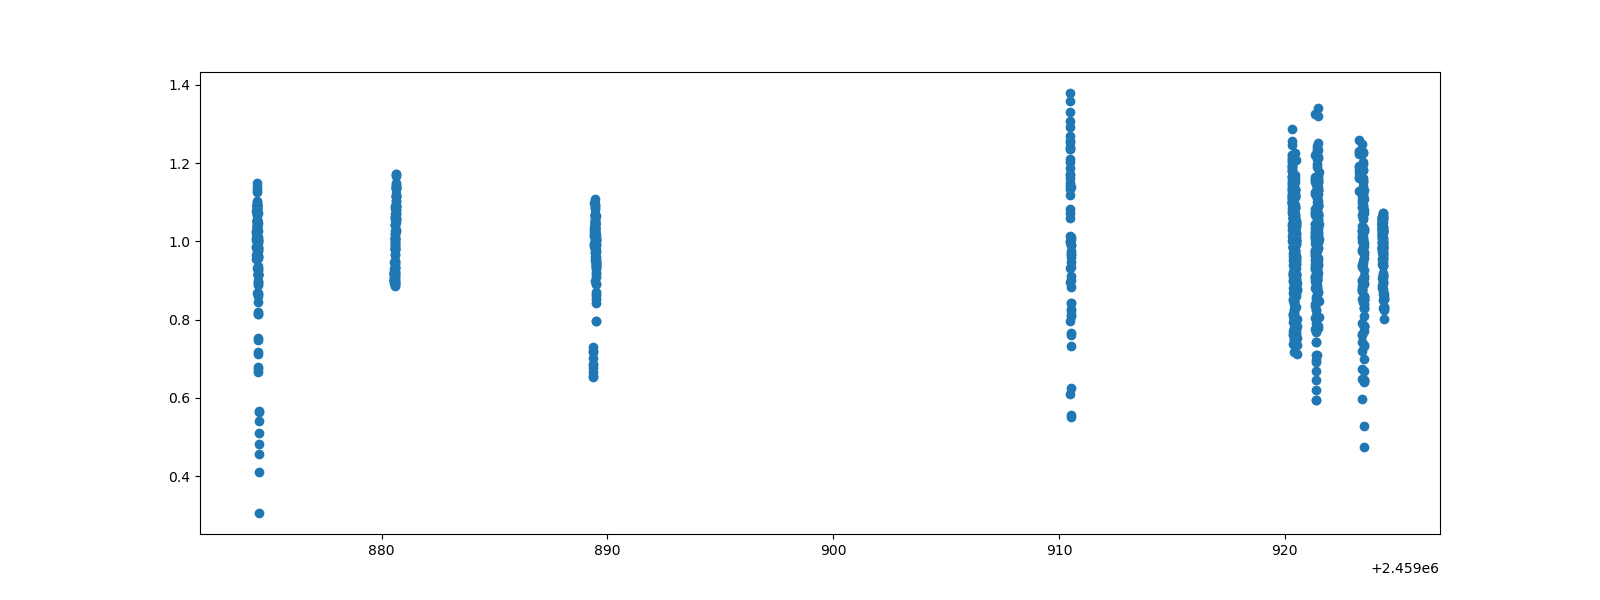

In [20]:
%matplotlib widget
plt.figure(figsize=(16,6))
plt.scatter(allObjDf['julianDate'], allObjDf['NORM_FLUX'])
allObjDf

In [ ]:
allObjDf.to_csv(f"{OBJ_DATA_DIR}/culledObjData.csv")